# A simple implementation of MPS Born Machine
[Pan Zhang](http://lib.itp.ac.cn/html/panzhang/)  
Institute of Theoretical Physics, Chinese Academy of Sciences  
Reference: Z. Han, J. Wang, H. Fan, L. Wang and P. Zhang, [Phys. Rev. X 8, 031012 (2018)](https://journals.aps.org/prx/abstract/10.1103/PhysRevX.8.031012)

Date: 2019 05 09


In [1]:
import sys
import numpy as np
import torch 
import math
%matplotlib inline
import matplotlib.pyplot as plt

torch.manual_seed(1) # Fix seed of the random number generators
np.random.seed(1)

The function below is used to plot mnist images

In [2]:
def show_imgs(imgs,l1=4,l2=5,s1=6,s2=6):
    """    Plot images    """
    plt.rcParams['figure.figsize']=(s1,s2)
    imgs=imgs.reshape([-1,28,28])
    g, ax = plt.subplots(l1,l2)
    for i in range(l1):
        for j in range(l2):
            a=i*l2+j
            if(a>=imgs.shape[0]):
                break
            ax[i][j].imshow(imgs[a,:,:],cmap='summer')
            ax[i][j].set_xticks([])
            ax[i][j].set_yticks([])
    plt.show()

### Data loading
$100$ MNIST images have been stored as "mnist_100_28x28_p0.5.npy".  
Each image contains $n=28\times 28=784$ pixels, each of which takes value $0$ or $1$.  
In our settings, each image is viewed as a product state in the Hilbert space of  dimension $2^n$.

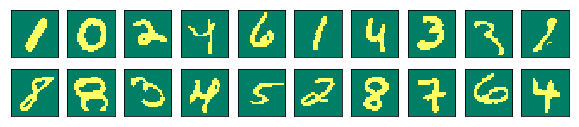

In [68]:
n=784 # number of qubits
m=20 # m images
data=np.load("mnist784_bin_1000.npy").astype(np.int32)
data=data[:m,:]
data=torch.LongTensor(data)
show_imgs(data,2,10,10,2)

### MPS initialization
Define the mps, which is a list of 3-way tensors containing random values 
<img src="imgs/mps.png" width="350px"/>

In [69]:
Dmax=30 # maximum bond dimension
bond_dims=[Dmax for i in range(n-1)]+[1]
tensors= [ torch.randn(bond_dims[i-1],2,bond_dims[i]) for i in range(n)]

Now check the bond dimensions and tensors

In [70]:
print("There are",len(tensors), "tensors")
print(bond_dims)
print(tensors[5].shape)

There are 784 tensors
[30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 3

Question: does the contration with one image give a probability of the image? Why?

Canonicalization using QR decompositions

In [71]:
def orthogonalize(site,going_right):
    dl=bond_dims[site-1] # left bond dimension
    d=bond_dims[site]   # current bond dimension
    if(going_right):
        A=tensors[site].view(dl*2,d) # A is a matrix unfolded from the current tensor
        Q,R=torch.qr(A)
        R/=R.norm() # devided by norm 
        tensors[site] = Q.contiguous().view(dl,2,-1)
        tensors[site+1] = (R@tensors[site+1].view(d,-1)).view(-1,2,bond_dims[site+1])
        bond_dims[site] = Q.shape[1] # economy QR, so the right dimension could be either dl or d
    else: # going left
        A=tensors[site].view(dl,d*2).t()
        Q,R=torch.qr(A)
        R/=R.norm() 
        tensors[site]=Q.t().contiguous().view(-1,2,d)
        tensors[site-1] = (tensors[site-1].view(-1,dl)@R.t()).view(bond_dims[site-2],2,-1)
        bond_dims[site-1] = Q.shape[1]


### MPS left canonicalization
Canonicalization gives several advantages:   
* It make the partition function of the model equals to $1$.  
* The isometries have condition number $1$, preserving very well the computation precisions.
<img src="imgs/mps_left.png" width="350px"/>

In [72]:
for site in range(n-1):
    orthogonalize(site,True)     

In [73]:
tensors[783].shape

torch.Size([30, 2, 1])

Canonicalization changes the bond dimensions, to see it

In [74]:
print(bond_dims)

[2, 4, 8, 16, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30

Now contracting mps with one image gives the probability amplitude of the image.

In [75]:
def get_psi():
    psi=torch.ones([m,1,1])
    for site in range(n):
        psi = psi @ tensors[site][:,data[:,site],:].permute(1,0,2)
    show_imgs(data,2,10,10,2)
    return(psi)

In [76]:
def gen_samples(ns):
    samples=np.zeros([ns,n])
    for site in range(n-1):# left canonicalize
        orthogonalize(site,True) 
    for s in range(ns):
        vec=torch.ones(1,1)
        for site in range(n-1,-1,-1):
            vec = (tensors[site].view(-1,bond_dims[site])@vec).view(-1,2)
            p0 = vec[:,0].norm()**2/ (vec.norm()**2)
            x = (0 if np.random.rand() < p0 else 1)
            vec = vec[:,x]
            samples[s][site]=x
    return samples

### Initialize cache for MPS
Computing probability of a image consists of contracting bonds from the first tensor to the last tensor. Lots of computation results can be re-used in the future computations, so we would like to store the contraction results in the cache.
Notice that the cache is for all images.

In [77]:
cache=[] 
cache.append( torch.ones([m,1,1])) # The initial elements, all images have cache 1
for site in range(n-1):
    B=cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)
    B /= B.abs().max()
    cache.append(  B  ) # batched matrix multiplications
cache.append( torch.ones(m,1,1)) # the last element, matrix [1,1] for all images

Notice that code ```B /= B.abs().max()``` is used to preserve computational precision, avoiding maximum value of the cache becomes too small. We can do this because the gradient is invariant by multiplying the cache by a constant, for each image.  
Length of the cache is $n+1$. In the caceh, for an image, each pixel has a correponding vector, denoting the temporary results in tensor contractions (from left to right or from right to left).
Let us look at the content of cache for image alpha=1:

In [78]:
alpha=1 # the image 1
print("cache site 1 ",cache[0][alpha])
print("cache site 2 ",cache[1][alpha])
print("cache site 3 ",cache[2][alpha])

cache site 1  tensor([[1.]])
cache site 2  tensor([[-0.3315, -1.0000]])
cache site 3  tensor([[ 0.0118, -0.4077, -0.2534,  1.0000]])


Then the probability amplitude $\psi$ for images can be obtained by

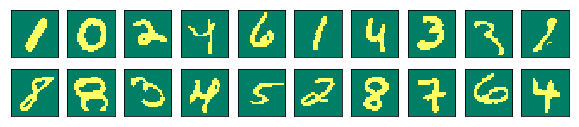

In [79]:
psi=get_psi()

Let us output the probablity for an image, which equals $|\psi|^2$ 

In [80]:
print("Probability of generating image 3 = %.5f"%(psi*psi)[3])

Probability of generating image 3 = 0.00000


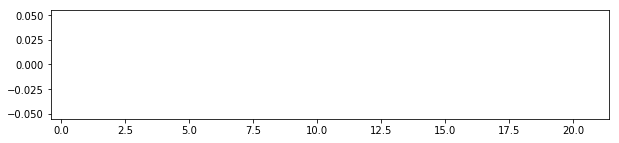

In [81]:
ax=plt.bar(range(1,psi.shape[0]+1),(psi**2).squeeze())

**Hey, the probability is $0$, what is wrong?**  

Because the space is too large and the model is randomly initialized!

Actually the purpose of training is exactly to increase the probability of given images. This is the so-called *maximum likelihood learning*.

The basic procedure is sweeping back and force, from right to left, then from left to right. During each sweep, the visited tensor is updated according to the *gradients* of the log-probability with respect to tensor elements.

## Training MPS
<img src="imgs/training.png" width="350px"/>

Some tips on the code:
* Only images with $i^{\mathrm{th}}$ element $v_i$ contribute to tensor element $A_{w_{i-1},v_i,w_i}$.
* ```torch.sum(left_vec.permute(0,2,1) @ right_vec.permute(0,2,1)``` computes $\Psi'(\mathbf{x})$.
* ```psi = left_vec @ A.permute(1,0,2) @right_vec ``` does not compute _real_ $\Psi$, as cache is rescaled to preserve precision. Thus one needs to call ```psi=get_psi()``` in order to compute correct probability amplitude $\Psi$.
* ```tensors_bak=tensors.copy()``` is to backup the training environment for restoring after generating images.
* ```@``` operator in ```left_vec @ A.permute(1,0,2) @right_vec ``` and in ```cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)``` works as batched matrix-matrix multiplications.
* In ```orthogonalize()```, imposing matrix $R$ to be norm-one using ```R/=R.norm() ``` actually let the partition function $Z=1$.

 Epoch #0, site #783 / 784           

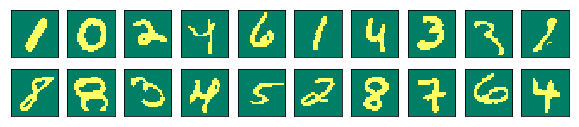

NLL=72.612, LowerBound=2.996, total_prob=0.000   generating samples...

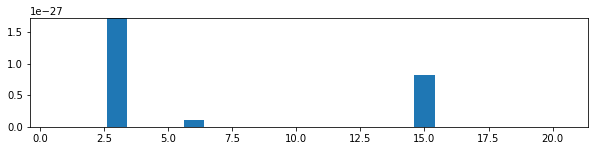

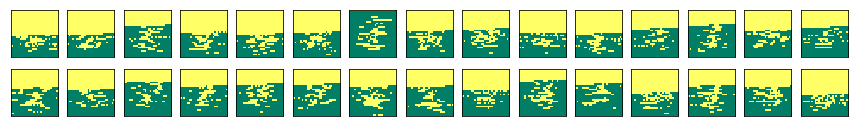

Press Enter to continue  
 Epoch #1, site #783 / 784           

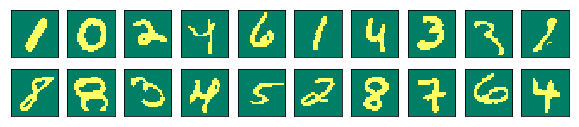

NLL=28.184, LowerBound=2.996, total_prob=0.000   generating samples...

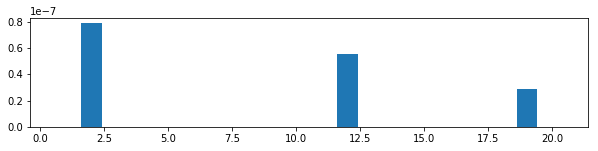

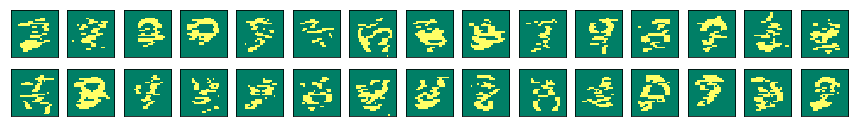

Press Enter to continue  
 Epoch #2, site #783 / 784           

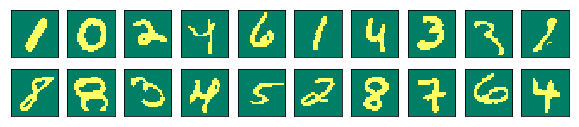

NLL=12.956, LowerBound=2.996, total_prob=0.003   generating samples...

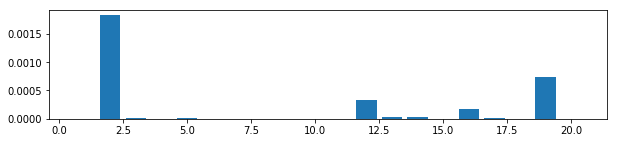

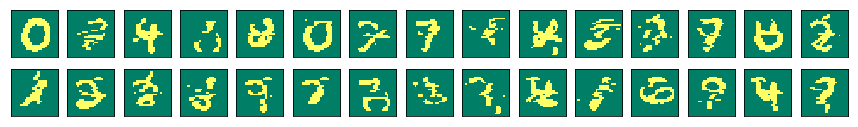

Press Enter to continue  
 Epoch #3, site #783 / 784           

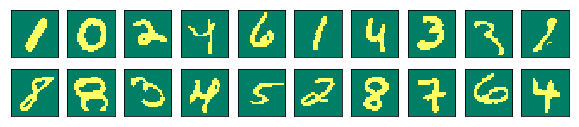

NLL=6.102, LowerBound=2.996, total_prob=0.095   generating samples...

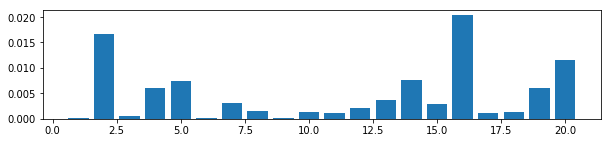

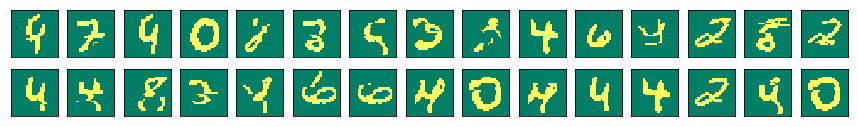

Press Enter to continue  
 Epoch #4, site #783 / 784           

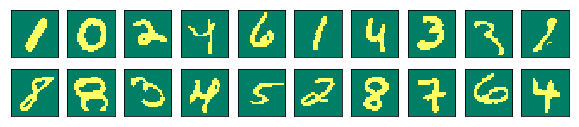

NLL=3.933, LowerBound=2.996, total_prob=0.460   generating samples...

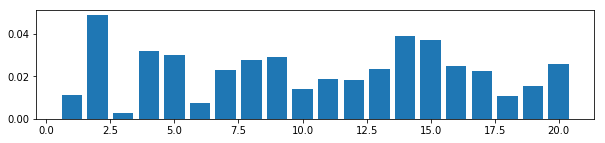

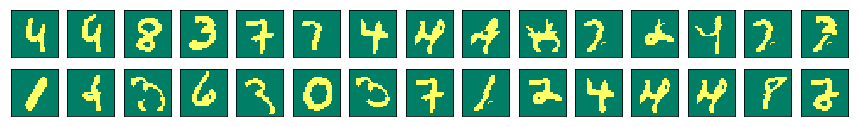

Press Enter to continue  
 Epoch #5, site #783 / 784           

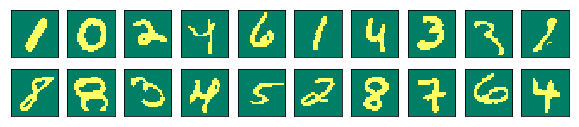

NLL=3.512, LowerBound=2.996, total_prob=0.709   generating samples...

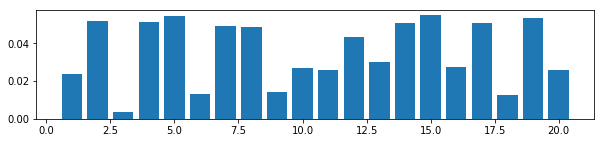

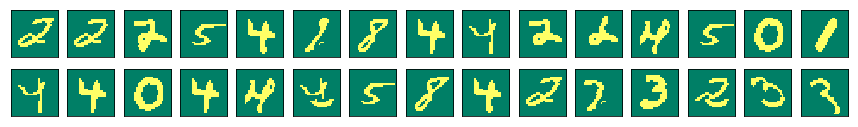

Press Enter to continue  
 Epoch #6, site #783 / 784           

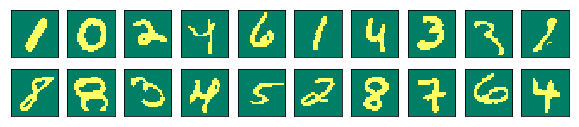

NLL=3.305, LowerBound=2.996, total_prob=0.826   generating samples...

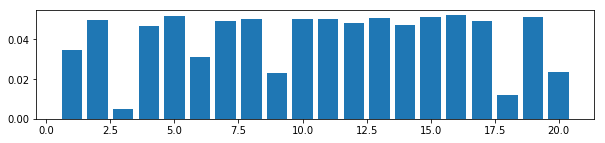

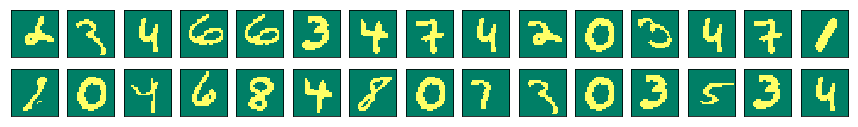

Press Enter to continue  
 Epoch #7, site #783 / 784           

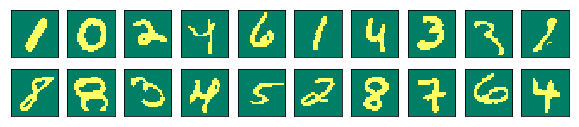

NLL=3.068, LowerBound=2.996, total_prob=0.938   generating samples...

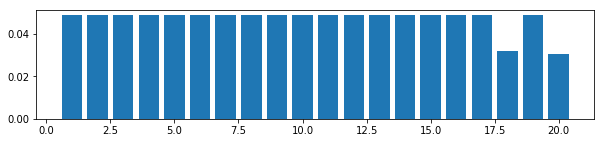

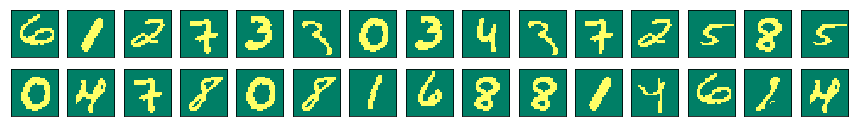

Press Enter to continue  
 Epoch #8, site #783 / 784           

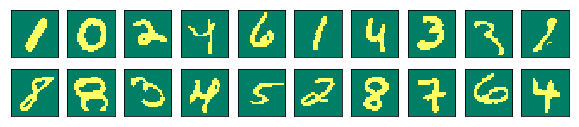

NLL=2.998, LowerBound=2.996, total_prob=1.000   generating samples...

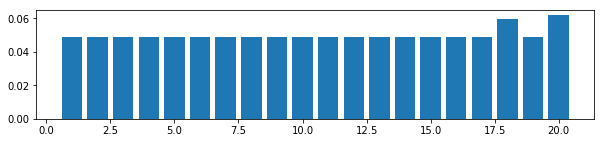

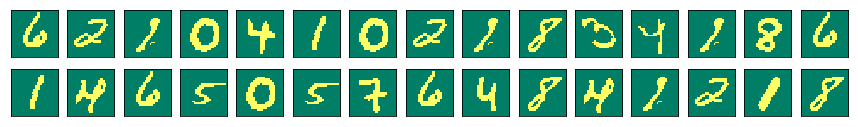

In [82]:
learning_rate=0.08
for epoch in range(9):    # one sweep, from right to left, then from left to right
    going_right=False
    for site in [i for i in range(n-1,0,-1)]+[i for i in range(n-1)]:
        # to update tensors[site] which is a 3-way tensor of size [dl,2,dr]
        sys.stdout.write("\r Epoch #%d, site #%d / %d           "%(epoch, site+1,n)); sys.stdout.flush()
        if(site==0): going_right=True
        gradients = torch.zeros_like(tensors[site])
        for i in [0,1]: # the pixel could be either 0 or 1
            idx=(data[:,site]==i).nonzero().type(torch.LongTensor).squeeze() # this returns indices of non-zero elements
            if(idx.numel()==0): continue
            left_vec = cache[site][idx,:,:] # a vector on the left of the site
            right_vec = cache[site+1][idx,:,:] # a vector on the right of the site
            A=tensors[site][:,data[idx,site],:]
            if(idx.numel()==1): 
                A=A.view(A.shape[0],1,A.shape[1])
                left_vec=left_vec.view(1,left_vec.shape[0],left_vec.shape[1])
                right_vec=right_vec.view(1,right_vec.shape[0],right_vec.shape[1])
            psi = left_vec @ A.permute(1,0,2) @right_vec 
            gradients[:,i,:] = torch.sum(left_vec.permute(0,2,1) @ right_vec.permute(0,2,1) / psi,0) 
        gradients = 2.0*(gradients/m-tensors[site])  
        tensors[site] += learning_rate * gradients/gradients.norm()
        orthogonalize(site,going_right)
        if(going_right):
            cache[site+1] = cache[site] @ tensors[site][:,data[:,site],:].permute(1,0,2)
            cache[site+1] /= cache[site+1].abs().max()
        else:
            cache[site] = tensors[site][:,data[:,site],:].permute(1,0,2) @ cache[site+1]
            cache[site] /= cache[site].abs().max()
    psi=get_psi()
    tensors_bak=tensors.copy()
    sys.stdout.write("NLL=%.3f, LowerBound=%.3f, total_prob=%.3f "%(-torch.mean(torch.log(psi*psi)),math.log(m),torch.sum(psi.squeeze()**2) ))
    sys.stdout.write("  generating samples...")
    ax=plt.bar(range(1,psi.shape[0]+1),psi.squeeze()**2)
    imgs=gen_samples(30)
    show_imgs(imgs,2,15,15,2)
    tensors=tensors_bak.copy()
    if(epoch < 8):
        input("Press Enter to continue  ")


### References for further reading:
* Ulrich Schollwock, “The density-matrix renormalization group in the age of matrix product states,” Annals of Physics 326, 96– 192 (2011).
* Tamara G. Kolda, and Brett W. Bader, "Tensor decompositions and applications", SIAM review 51, 455 (2009).
* Ivan V Oseledets, “Tensor-train decomposition,” SIAM Journal on Scientific Computing 33, 2295–2317 (2011).
* Edwin Miles Miles Stoudenmire and David J. Schwab, “Supervised Learning with Quantum-Inspired Tensor Networks,” Advances in Neural Information Processing Systems 29, 4799 (2016), arXiv:1605.05775.
* Alexander Novikov, Mikhail Trofimov, and Ivan Oseledets, “Exponential machines,” arXiv:1605.05775 (2016).
* Jinguo Liu, and Lei Wang,Differentiable Learning of Quantum Circuit Born Machine, arXiv:1804.04168 (2018).
* Edwin Miles Stoudenmire, “Learning relevant features of data with multi-scale tensor networks,” Quantum Science and Technology (2018).